In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import numpy as np
import xarray as xr
import downscale as down
import matplotlib.pyplot as plt

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

In [2]:
# down.matplotlib_update_settings()

In [3]:
def extract_sample_data(inputfile, outputfile,
                        clat=34.875, clon=-98.125, npix=3, dx=0.25):
    '''------------------------------------------------------------------------
    Extract a given bounding box centered in (clat, clon) with size npix
    grid cells from an input hdf file
    and save it as nc dataset for further analysis
    ------------------------------------------------------------------------'''
    # f = h5py.File(os.path.join(cdat.tmpa_dir, 'data_tmpa_3h.hdf5'), "r")
    f = h5py.File(inputfile, "r")
    # print(list(f.keys()))
    # print(list(f.attrs()))
    tmpalat = f['lat'][:]
    tmpalon = f['lon'][:]
    dates_int = f['dates'][:]
    hours_int = f['hours'][:]
    dset = f['prcp']
    print('dataset shape = {}'.format(dset.shape)) # too large to fit in memory!
    x = da.from_array(dset, chunks=(6, 6, 300))
    # UTC time
    dates = [datetime.strptime(str(integd)+str(inthour), '%Y%m%d%H')
                    for integd, inthour in zip(dates_int, hours_int)]
    # create xarray
    xrs0 = xr.DataArray(x,  coords={'lon':tmpalon, 'lat':tmpalat, 'time':dates},
                                                    dims=('lon', 'lat', 'time'))
    # set negative values to NaN (missing values)
    xrs = xrs0.where(xrs0 >= -0.001)
    # now extract a bounding box of interest:
    # clat = 34.875
    # clon = -98.125
    # dx = 0.25
    # npix = 3
    buffer = 0.50*npix*dx
    eps = 1e-4 # to make sure to include boundaires -> add an eps buffer
    # eps = 0 # to make sure to include boundaires -> add an eps buffer
    solat = clat - buffer + eps
    nolat = clat + buffer + eps
    ealon = clon + buffer + eps
    welon = clon - buffer + eps
    bcond = np.logical_and(
                np.logical_and( xrs.lat > solat, xrs.lat < nolat),
                np.logical_and( xrs.lon > welon, xrs.lon < ealon))
    # XARRAY WITH VALUES LOADED IN MEMORY
    box_3h = xrs.where(bcond, drop = True).load()
    print(box_3h.shape)
    box_3h.to_netcdf(outputfile)

In [4]:
extract_box = True # do it only once
# inputfile = os.path.join('..', cdat.tmpa_dir, 'data_tmpa_3h.hdf5')
tmpa_dir = os.path.join('..', 'data', 'tmpa_conus_data')
inputfile = os.path.join(tmpa_dir, 'data_tmpa_3h.hdf5')
outputdir = os.path.join('..', 'data', 'sample_data')
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
# outputfile = os.path.join('..', 'sample_data','okla.nc')
outputfile = os.path.join(outputdir,'okla.nc')
clat = 34.875
clon = -98.125
dx = 0.25
npix = 3
if extract_box:
    extract_sample_data(inputfile, outputfile,
                        clat=clat, clon=clon, npix=npix,dx=dx)

dataset shape = (280, 112, 2433)
(3, 3, 2433)


In [5]:
# box_3h = xr.open_dataset(outputfile)
box_3h = xr.open_dataarray(outputfile)
Tr = 100

res = {}  # initialize dictionary for storing results

In [6]:
DATA = h5py.File(inputfile, "r")
ALL_lat = DATA['lat'][:]
ALL_lon = DATA['lon'][:]
lon2d, lat2d = np.meshgrid(ALL_lon, ALL_lat)
del DATA

lon2d_box, lat2d_box = np.meshgrid(box_3h['lon'], box_3h['lat'])

/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


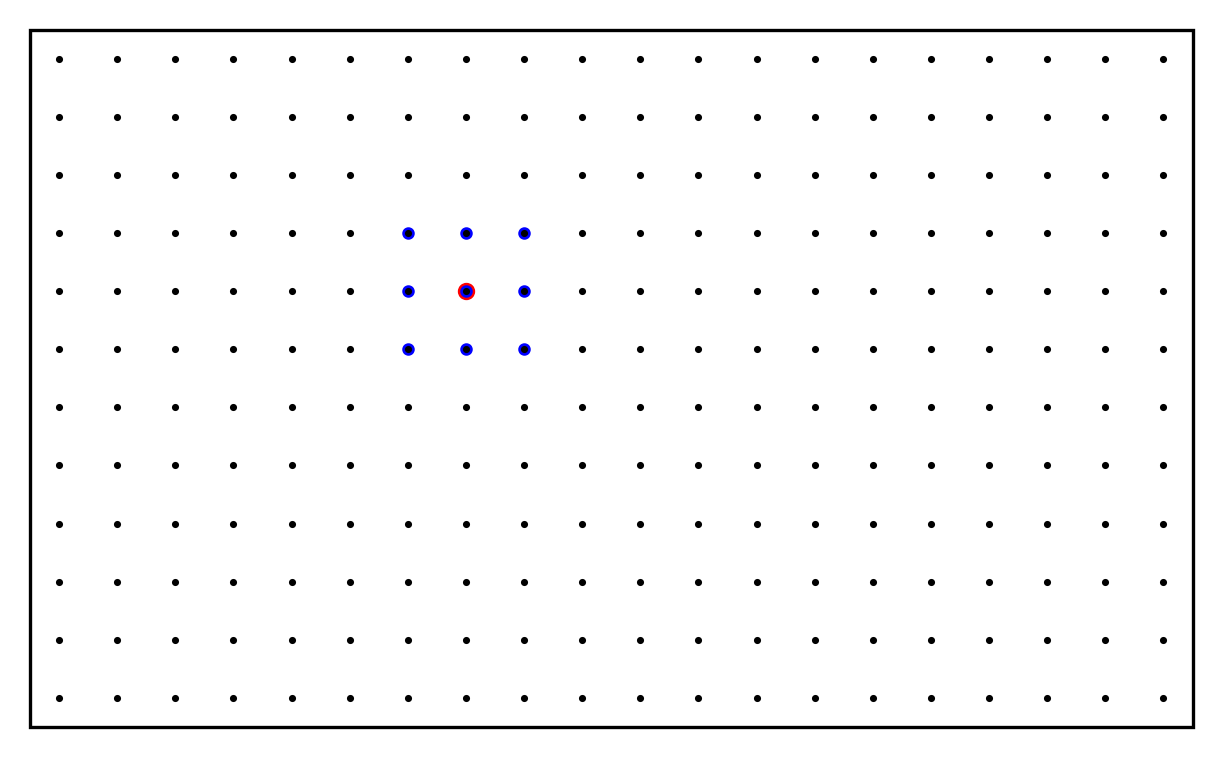

In [7]:
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,5),dpi=300)
gs = gridspec.GridSpec(1,1)

# =======================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')

ax1.set_extent([-100, -95, 33, 36], crs=proj)

ax1.scatter(clon,clat,s=10, color='r')
ax1.scatter(lon2d_box, lat2d_box,s=4, color='b')
ax1.scatter(lon2d, lat2d ,s=0.5, color='k')

In [8]:
# downscaling:
print('Example: running the downscaling function')
init_time = time.time()
downres = down.downscale(box_3h, Tr, thresh=1.0, L0=0.0001, toll=0.005,
                            acf='mar', save_yearly=True,
                            maxmiss=300, clat=clat, clon=clon,
                            opt_method='genetic', plot=True)#maxmiss=36
end_time = time.time()
exec_time = end_time - init_time
print('Downscaling, execution time was = {} minutes'.format(exec_time/60))

Example: running the downscaling function
Downscaling Intermittency


/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/arturo/anaconda3/envs/AXE/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will b

Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 0.0028012539959308036
differential_evolution step 2: f(x)= 0.002574521928473828
differential_evolution step 3: f(x)= 0.0014528018152017218
Polishing solution with 'L-BFGS-B'
integration domain is zero
Downscaling pdf - global Weibull parameters
[67.]
[12.68544449]
[0.83916238]
Downscaling pdf - yearly Weibull parameters
[56.]
[12.68149908]
[0.83875668]
Downscaling, execution time was = 1.423258908589681 minutes


In [10]:
downres

{'NYs': array([60.]),
 'CYs': array([11.79931403]),
 'WYs': array([0.82803848]),
 'NYd': array([56.]),
 'CYd': array([12.68149908]),
 'WYd': array([0.83875668]),
 'Tr': 100,
 'mev_d': 166.52222327754822,
 'mev_s': 161.75412129498486,
 'gam_d': 0.95048589218289,
 'gam_s': 0.9646652936895838,
 'beta': 1.0657762542861011,
 'Nd': 67.0,
 'Cd': 12.685444494659366,
 'Wd': 0.8391623780956292,
 'Ns': 71,
 'Cs': 11.7993140329166,
 'Ws': 0.8280384818656508,
 'eps_s': 308.7325718827982,
 'alp_s': 0.8488013034394477,
 'eps_d': 40.25877808847465,
 'alp_d': 0.1565091945903546,
 'corr_down_success': True,
 'corr_down_funval': 0.0014412772140475398,
 'w_down_funval': 8.788525462932739e-13,
 'thresh': 1.0,
 'clat': 34.875,
 'clon': -98.125,
 'corr_plot': <Figure size 640x480 with 1 Axes>,
 'Taylor_contour': <Figure size 640x480 with 2 Axes>}